In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 2041.4 MB 3.4 kB/s              �████████           | 1334.5 MB 106.5 MB/s eta 0:00:07
     |████████████████████████████████| 23.1 MB 73.0 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1+cu111
    Uninstalling torch-1.9.1+cu111:
      Successfully uninstalled torch-1.9.1+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1+cu111
    Uninstalling torchvision-0.10.1+cu111:
      Successfully uninstalled torchvision-0.10.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 0.9.1 requires torch==1.9.1, but you have torch 1.9.0+cu111 which is incompatible.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     |█████████████

In [3]:
from mmcv import collect_env
collect_env()

/opt/conda/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


{'sys.platform': 'linux',
 'Python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) [GCC 9.4.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla T4',
 'CUDA_HOME': '/opt/conda',
 'NVCC': 'Cuda compilation tools, release 11.4, V11.4.48',
 'GCC': 'gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compu

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.25.3
11.1
GCC 7.3


**Perform Inference with An MMDet detector**

In [5]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth

--2022-11-07 01:32:13--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.86
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291982 (160M) [application/octet-stream]
Saving to: ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’

checkpoints/faster_ 100%[===================>] 159.54M  12.9MB/s    in 13s     

2022-11-07 01:32:26 (12.7 MB/s) - ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’ saved [167291982/167291982]



In [6]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

**Inference the detector**

In [7]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/aiffel/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


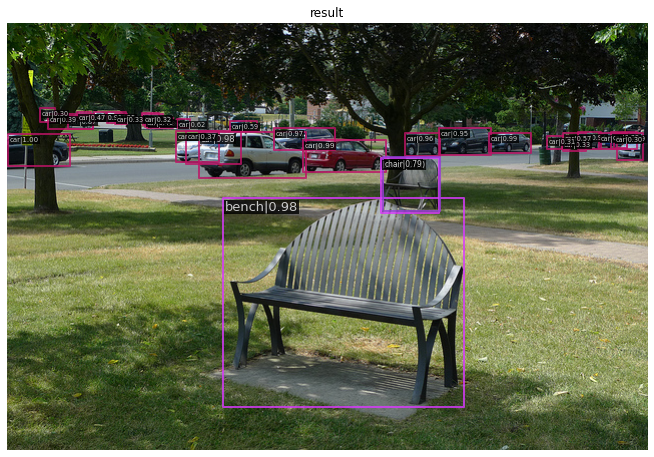

In [8]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

**Train A Detector on A Customized Dataset**

In [9]:
# download, decompress the data
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-11-07 01:32:43--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.86
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  5.00MB/s    in 1.3s    

2022-11-07 01:32:46 (5.00 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [10]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (1.8.0-1).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfcitx-utils0
  libfontembed1 li

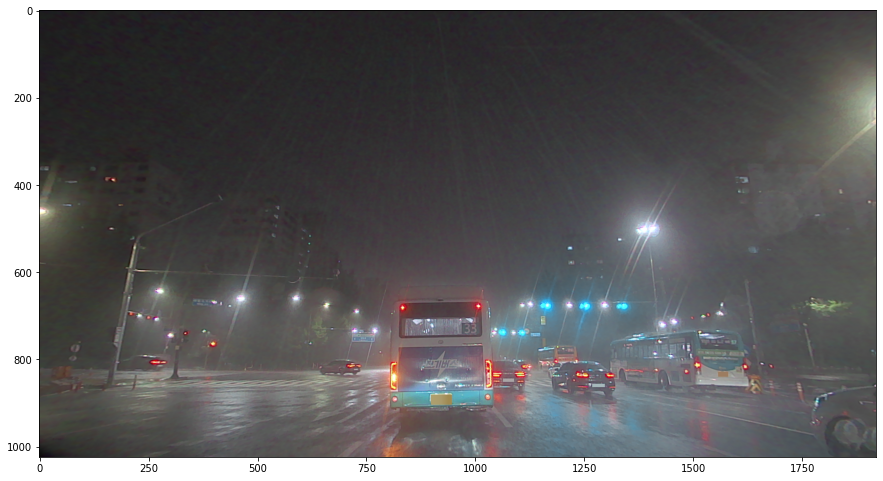

In [20]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('aimmo/image/1659964852731_FR-View-CMR-Wide.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [21]:
# Check the label of a single image
!cat aimmo/annotation/1659964852731_FR-View-CMR-Wide_Bbox_GT.json

{
    "filename": "1659964852731_FR-View-CMR-Wide.png",
    "parent_path": "/batch_11/20220808/2022-08-08_22-20-52_ADCV1-ADS-LC1/FR-View-CMR-Wide",
    "unix_timestamp": 1659964852731,
    "file_format": "png",
    "capacity": 1.81,
    "vehicle_id": "AIMMO-ADCV1",
    "region_name": "경기 성남시 분당구",
    "location": "야탑동 327-1",
    "length": 14,
    "framerate": 30,
    "size": "1920*1024",
    "data_purpose": "train",
    "weather": "rain",
    "time": "night",
    "road_feature": "r_cityroad",
    "road_type": "intersection",
    "location_feature": "other",
    "driving_scenario": "left_turn",
    "ego_long_vel_level": "low",
    "season": "summer",
    "illumination_status": "backlight_streetlight",
    "road_status": "wet",
    "crowd_level": "high",
    "scene_att": "frame",
    "sensor_name": "FR_View_CMR_Wide",
    "sensor_status": "waterdrop",
    "sensor_hfov": 122,
    "sensor_vfov": 74,
    "gps_mode": "rtk_integer",
    "gps_latitude": 37.41728721497424,
    "gps_longitude":

In [22]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class AimmoDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image', 'annotation')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.json'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

**Modify the config**

In [24]:
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

**Train a new detector**

In [25]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'AimmoDataset'
cfg.data_root = 'aimmo/'

cfg.data.test.type = 'AimmoDataset'
cfg.data.test.data_root = 'aimmo/'
cfg.data.test.ann_file = '1659964864459_FR-View-CMR-Wide_Bbox_GT.json'
cfg.data.test.img_prefix = 'image'

cfg.data.train.type = 'AimmoDataset'
cfg.data.train.data_root = 'aimmo/'
cfg.data.train.ann_file = '1659964864459_FR-View-CMR-Wide_Bbox_GT.json'
cfg.data.train.img_prefix = 'image'

cfg.data.val.type = 'AimmoDataset'
cfg.data.val.data_root = 'aimmo/'
cfg.data.val.ann_file = '1659964865459_FR-View-CMR-Wide_Bbox_GT.json'
cfg.data.val.img_prefix = 'image'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

In [26]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
cfg.device='cuda'
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

FileNotFoundError: AimmoDataset: [Errno 2] No such file or directory: 'aimmo/image/{.jpg'

**Understand the log**

In [27]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./tutorial_exps

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 206), started 0:42:42 ago. (Use '!kill 206' to kill it.)

**Test the Trained Detector**

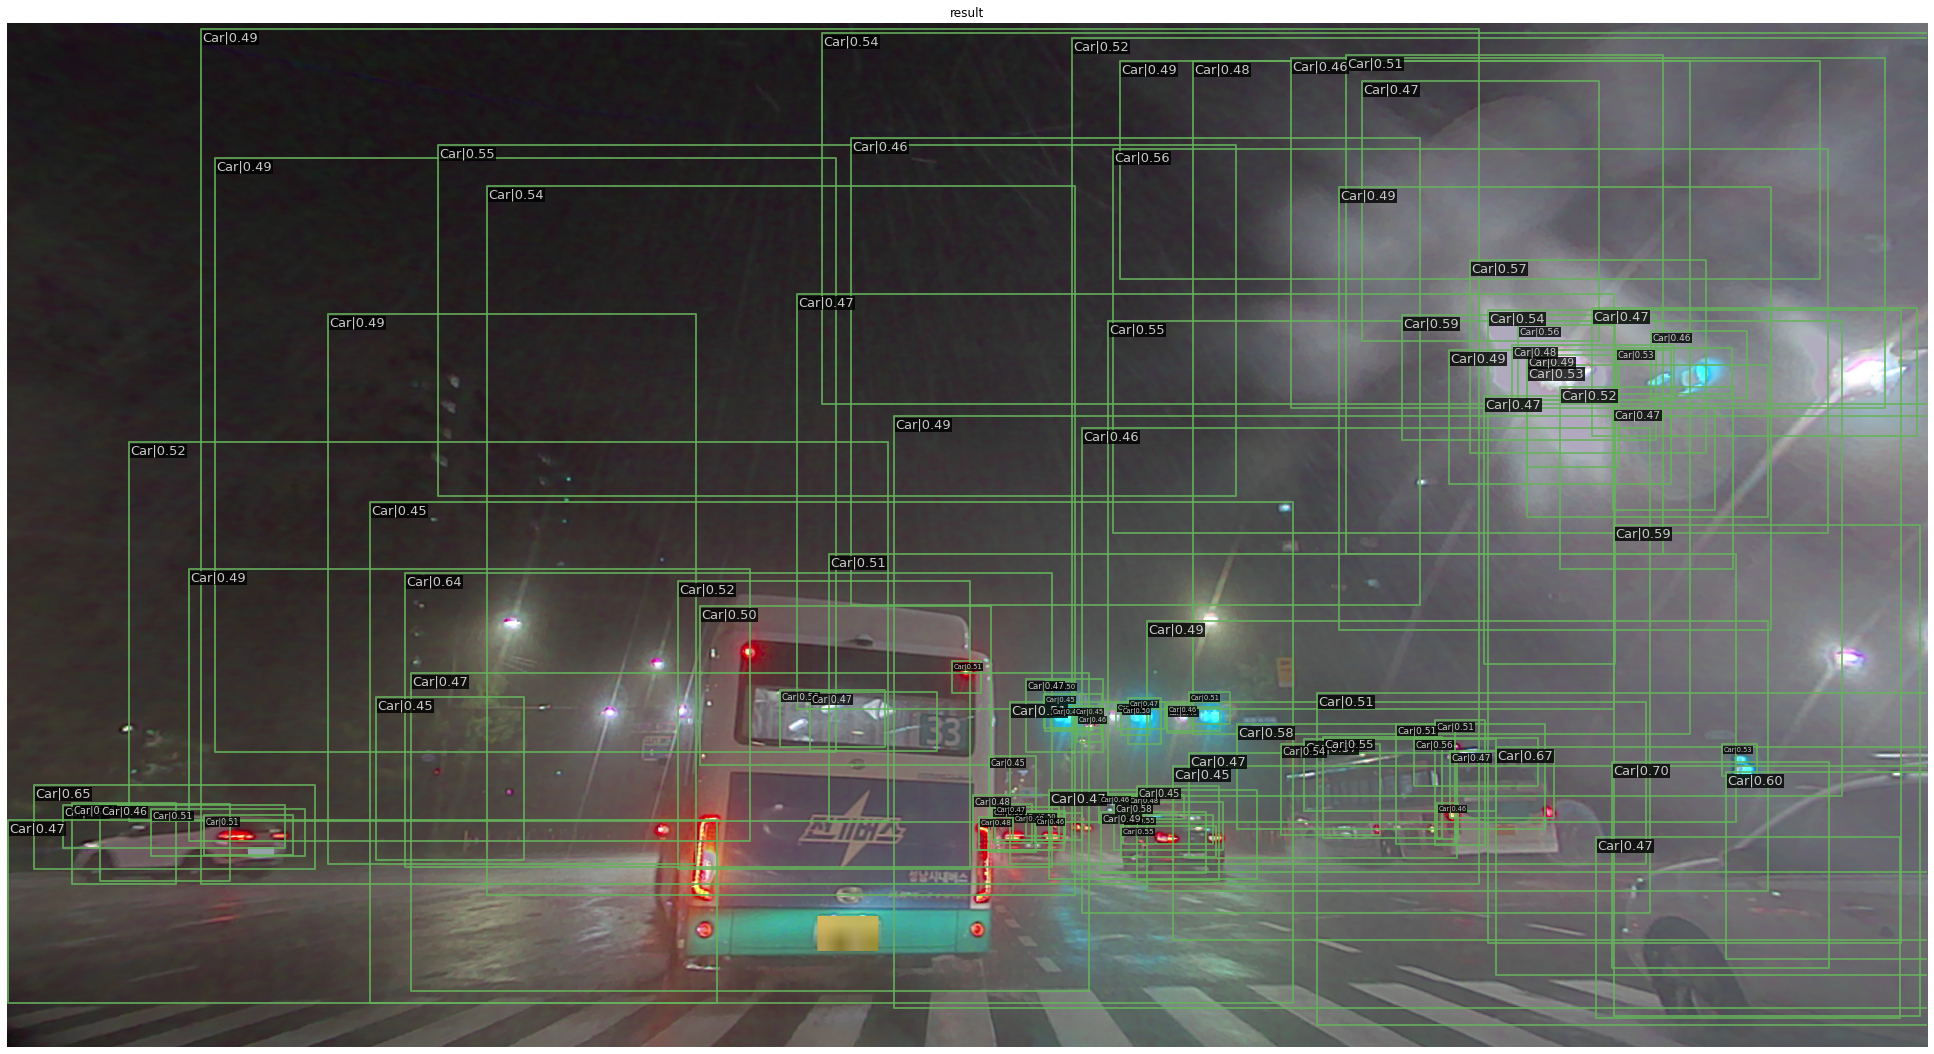

In [28]:
img = mmcv.imread('aimmo/image/1659964856829_FR-View-CMR-Wide.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)